[info] Using INPUT_FILE=C:\Users\moura\OneDrive\Bureau\DMS\test\watataaaaaaaaaaaa.png



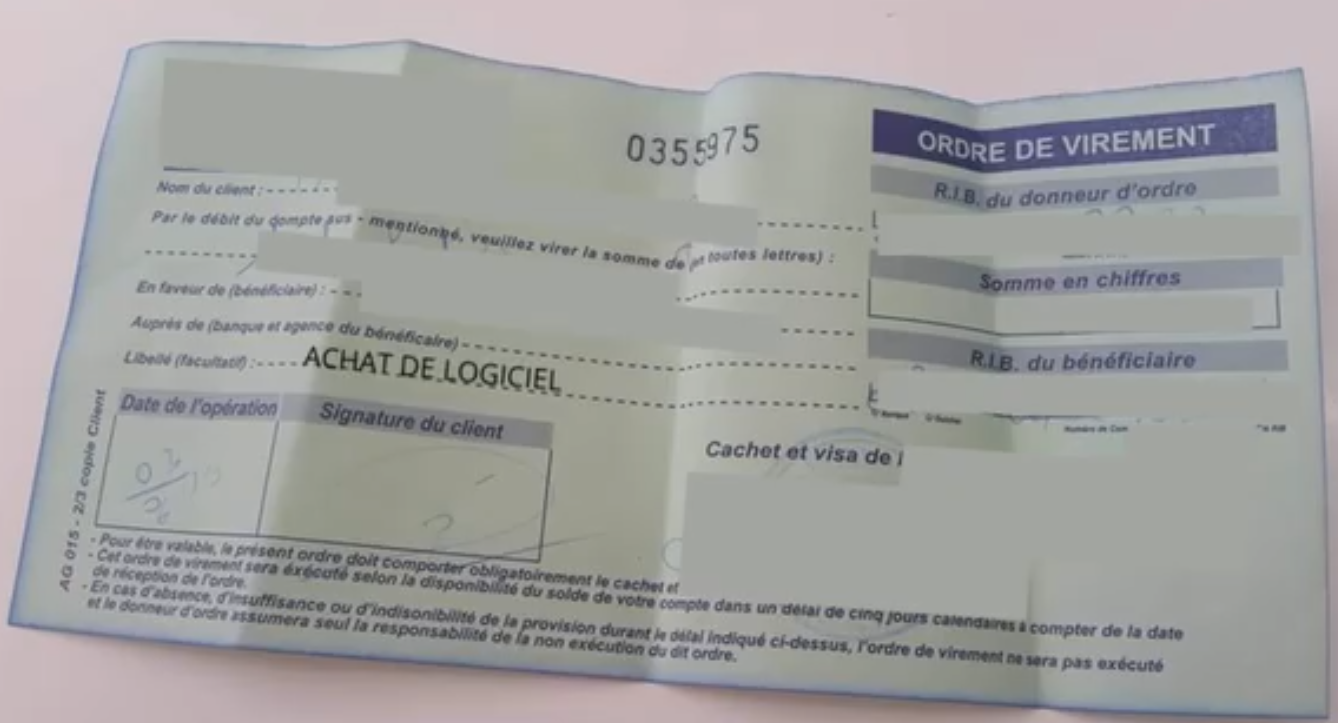
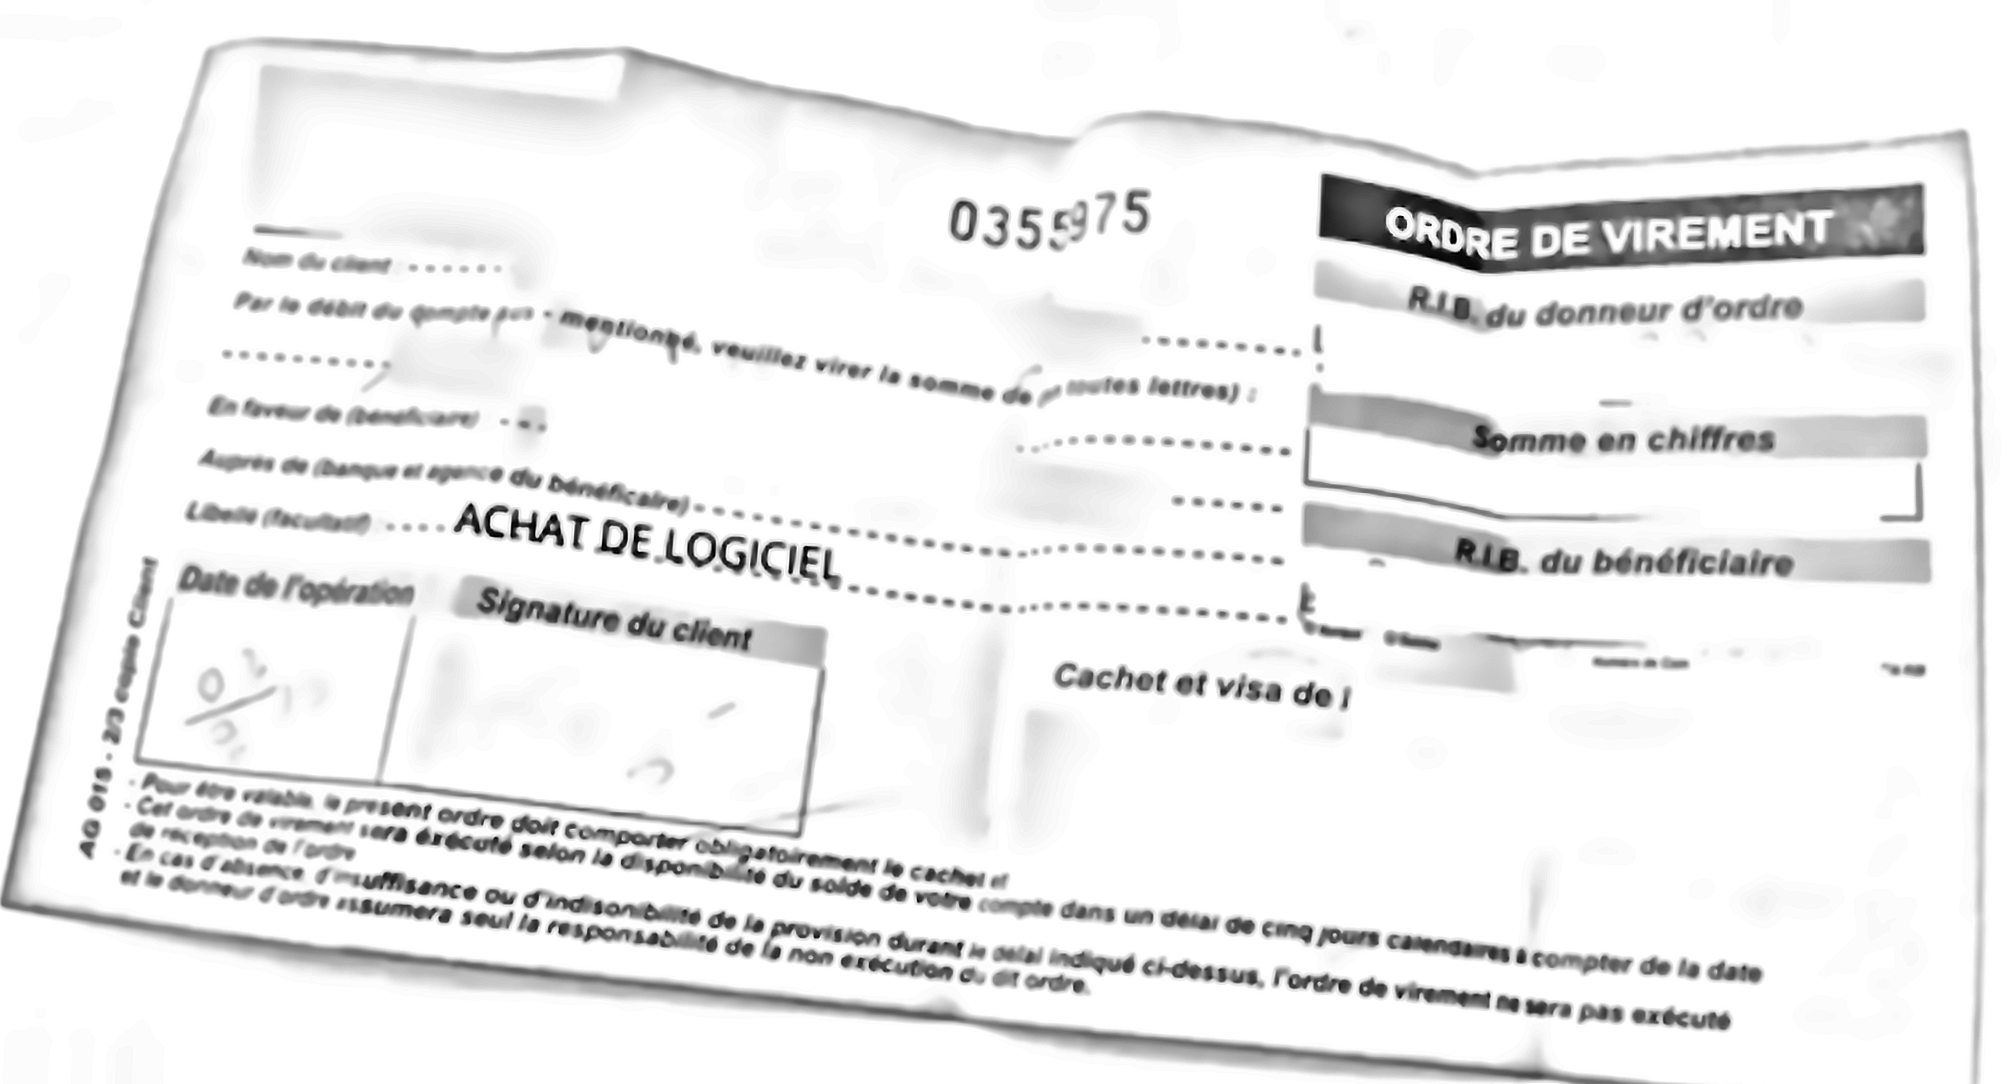
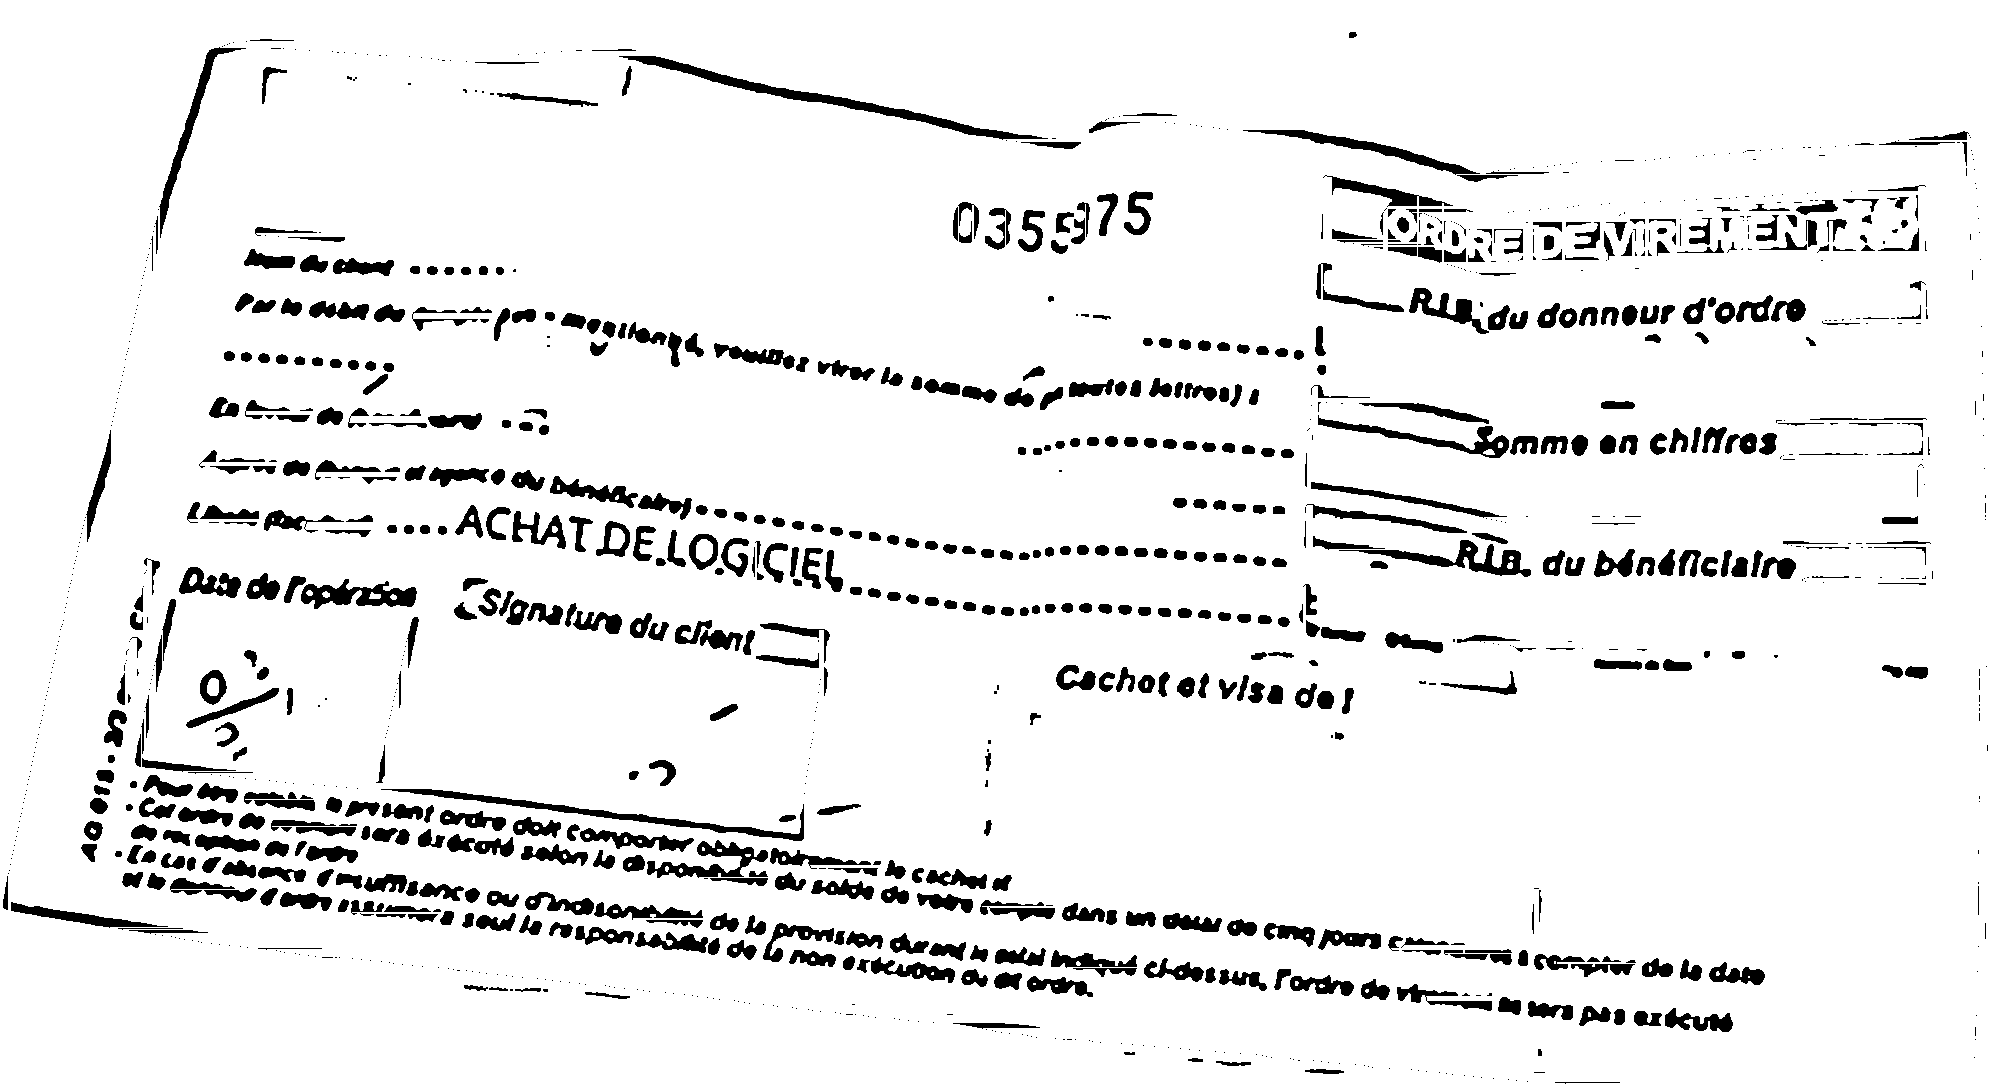
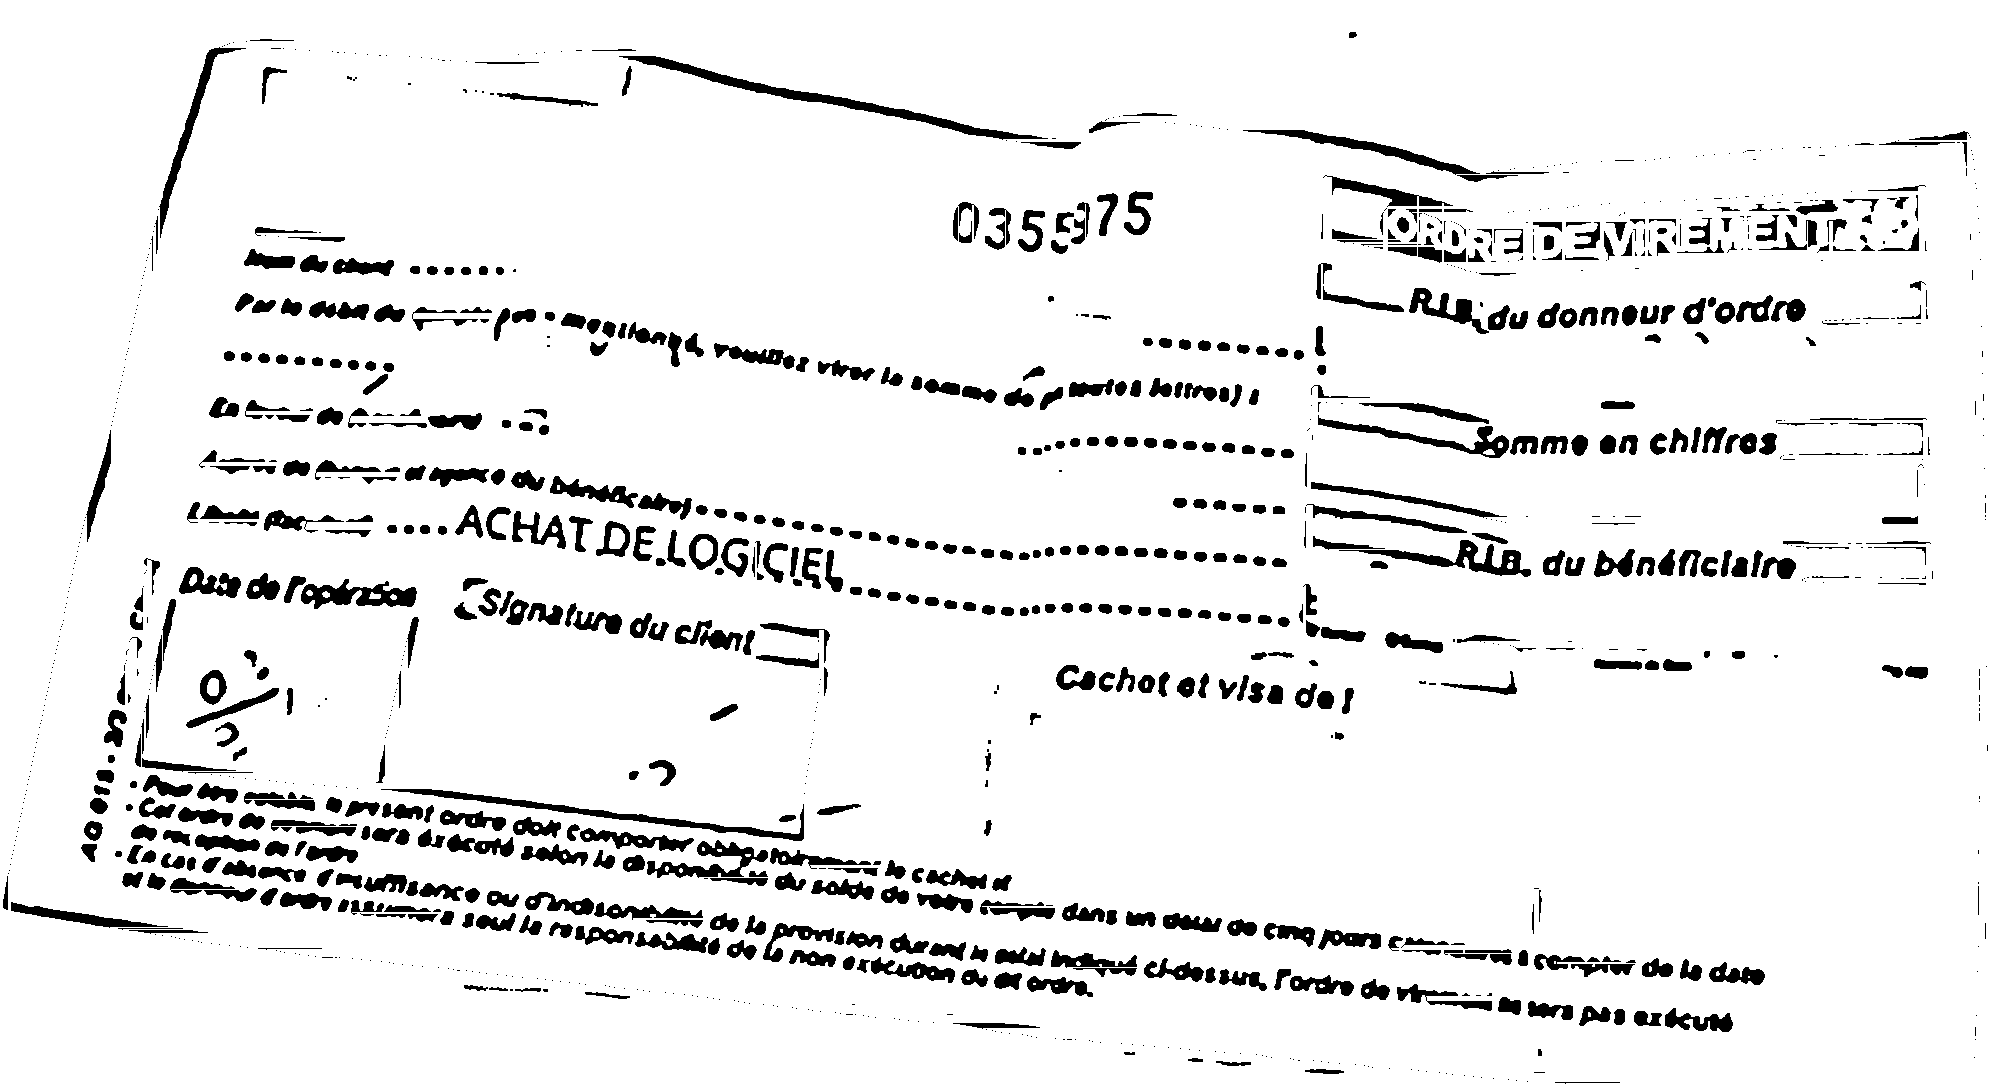

[info] OpenCV: angle deskew (texte) = 1.76 deg


In [29]:
"""
Dependencies:
  * Python 3.8+
  * pytesseract
  * pillow
  * Tesseract binary with tessdata
"""

import argparse
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Optional

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

try:
    import numpy as np  # type: ignore
except ImportError:  # pragma: no cover
    np = None

# --- OpenCV (optionnel) ---
try:
    import cv2  # type: ignore
except ImportError:  # pragma: no cover
    cv2 = None

# --- Notebook inline display (optionnel) ---
try:
    from IPython.display import display as ipy_display, HTML  # type: ignore
except Exception:  # pragma: no cover
    ipy_display = None
    HTML = None

try:
    from io import BytesIO
    import base64
except Exception:  # pragma: no cover
    BytesIO = None
    base64 = None

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    SCRIPT_DIR = Path.cwd()

DEFAULT_LANG = "fra"
DEFAULT_CONTRAST = 1.5
DEFAULT_SHARPNESS = 1.2
DEFAULT_BRIGHTNESS = 1.0
DEFAULT_UPSCALE = 1.5
DEFAULT_DPI = 300

INPUT_FILE: Optional[str] = "watataaaaaaaaaaaa.png"
SHOW_PREPROCESSED = True

# Active/désactive le prétraitement avancé OpenCV
USE_OPENCV_ADVANCED = True

# Options OpenCV avancées
OPENCV_TRY_PERSPECTIVE = True
OPENCV_DESKEW = True
OPENCV_REMOVE_TABLE_LINES = True
OPENCV_USE_SAUVOLA = False

# Ajouts demandés quand OpenCV est utilisé
OPENCV_FORCE_OSD_ROTATE = True       # rotation 90/180/270 via OSD Tesseract (orientation)
OPENCV_FIX_ILLUMINATION = True       # correction ombres/illumination
OPENCV_LIGHT_DENOISE = True          # débruitage léger
OPENCV_LOCAL_CONTRAST = True         # contraste local (CLAHE)
OPENCV_SHARPEN = True                # netteté (unsharp mask)

# Debug / affichages OpenCV
OPENCV_SHOW_RECTIFIED = True
OPENCV_LAST_DOC_QUAD = None           # 4 points du doc détecté (si trouvé)
OPENCV_LAST_DOC_ANGLE = None          # angle estimé du doc (deg) via TL->TR (après détection contour)
OPENCV_LAST_DESKEW_ANGLE = None       # angle deskew détecté (deg) (texte incliné)
OPENCV_DEBUG_WARPED_GRAY = None       # doc après correction perspective (gray)
OPENCV_DEBUG_DESKEWED_GRAY = None     # doc gray après rotation parfaite
OPENCV_DEBUG_DESKEWED_BIN = None      # doc binaire final


@dataclass
class EnhanceOptions:
    contrast: float = DEFAULT_CONTRAST
    sharpness: float = DEFAULT_SHARPNESS
    brightness: float = DEFAULT_BRIGHTNESS
    upscale: float = DEFAULT_UPSCALE
    gamma: Optional[float] = None
    pad: int = 0
    median: Optional[int] = None
    unsharp_radius: Optional[float] = None
    unsharp_percent: int = 150
    invert: bool = False
    autocontrast_cutoff: Optional[int] = None
    equalize: bool = False
    auto_rotate: bool = False
    otsu: bool = False
    threshold: Optional[int] = None


def build_config(
    oem: Optional[int],
    psm: Optional[int],
    base_flags: Iterable[str],
    dpi: Optional[int],
    tessdata_dir: Optional[Path],
    user_words: Optional[Path],
    user_patterns: Optional[Path],
) -> str:
    parts: List[str] = []
    if oem is not None:
        parts.append(f"--oem {oem}")
    if psm is not None:
        parts.append(f"--psm {psm}")
    if dpi is not None:
        parts.append(f"--dpi {dpi}")
    if tessdata_dir is not None:
        parts.append(f'--tessdata-dir "{tessdata_dir}"')
    if user_words is not None:
        parts.append(f'--user-words "{user_words}"')
    if user_patterns is not None:
        parts.append(f'--user-patterns "{user_patterns}"')
    parts.extend(base_flags)
    return " ".join(parts)


def ensure_environment(lang: str) -> None:
    try:
        _ = pytesseract.get_tesseract_version()
    except pytesseract.TesseractNotFoundError:
        sys.exit("Tesseract binary not found on PATH. Install it and its language data.")
    if lang:
        try:
            available = set(pytesseract.get_languages(config=""))
            requested = set(lang.split("+"))
            missing = requested - available
            if missing:
                print(
                    f"Warning: missing languages: {', '.join(sorted(missing))}. "
                    f"Available: {', '.join(sorted(available))}",
                    file=sys.stderr,
                )
        except pytesseract.TesseractError:
            pass


def auto_rotate_if_needed(img: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    if not enhance.auto_rotate:
        return img
    try:
        osd = pytesseract.image_to_osd(img)
        angle = None
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                try:
                    angle = int(line.split(":")[1].strip())
                except ValueError:
                    angle = None
                break
        if angle is not None and angle % 360 != 0:
            return img.rotate(-angle, expand=True)
    except Exception:
        pass
    return img


def osd_rotate(img: Image.Image) -> Image.Image:
    # Rotation (souvent 90/180/270) via OSD Tesseract
    try:
        osd = pytesseract.image_to_osd(img)
        angle = None
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                try:
                    angle = int(line.split(":")[1].strip())
                except ValueError:
                    angle = None
                break
        if angle is not None and angle % 360 != 0:
            return img.rotate(-angle, expand=True)
    except Exception:
        pass
    return img


# ----------------- Notebook display helpers -----------------

def _pil_to_b64_png(img: Image.Image) -> Optional[str]:
    if BytesIO is None or base64 is None:
        return None
    buf = BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("ascii")


def display_side_by_side(images: List[Image.Image], titles: List[str]) -> None:
    # Affichage inline (Jupyter) sans ouvrir de fenêtre externe
    if ipy_display is None or HTML is None:
        return

    blocks = []
    for img, title in zip(images, titles):
        b64 = _pil_to_b64_png(img)
        if not b64:
            continue
        blocks.append(
            f"""
            <div style="display:inline-block; vertical-align:top; margin-right:16px;">
              <div style="font-family:monospace; font-size:13px; margin-bottom:6px;">{title}</div>
              <img src="data:image/png;base64,{b64}" style="max-width:none; height:auto;" />
            </div>
            """
        )
    ipy_display(HTML(f"<div style='white-space:nowrap;'>{''.join(blocks)}</div>"))


# ----------------- OpenCV advanced helpers -----------------

def pil_to_cv_gray(pil_img: Image.Image):
    if np is None:
        raise RuntimeError("numpy is required for OpenCV preprocessing")
    return np.array(pil_img.convert("L"), dtype=np.uint8)


def cv_gray_to_pil(gray):
    if np is None:
        raise RuntimeError("numpy is required for OpenCV preprocessing")
    gray = np.clip(gray, 0, 255).astype(np.uint8)
    return Image.fromarray(gray, mode="L")


def _order_points(pts):
    if np is None:
        raise RuntimeError("numpy is required for OpenCV preprocessing")
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect


def _four_point_warp(gray, pts):
    if cv2 is None:
        return gray
    rect = _order_points(pts.astype("float32"))
    (tl, tr, br, bl) = rect

    widthA = float(np.linalg.norm(br - bl))
    widthB = float(np.linalg.norm(tr - tl))
    maxW = int(max(widthA, widthB))

    heightA = float(np.linalg.norm(tr - br))
    heightB = float(np.linalg.norm(tl - bl))
    maxH = int(max(heightA, heightB))

    dst = np.array(
        [[0, 0], [maxW - 1, 0], [maxW - 1, maxH - 1], [0, maxH - 1]],
        dtype="float32",
    )

    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(
        gray,
        M,
        (maxW, maxH),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE,
    )


def try_perspective_correction(gray):
    # Correction perspective si contour "document" trouvé
    global OPENCV_LAST_DOC_QUAD, OPENCV_LAST_DOC_ANGLE, OPENCV_DEBUG_WARPED_GRAY

    if cv2 is None or np is None:
        return gray

    OPENCV_LAST_DOC_QUAD = None
    OPENCV_LAST_DOC_ANGLE = None
    OPENCV_DEBUG_WARPED_GRAY = None

    h, w = gray.shape[:2]
    scale = 900.0 / max(h, w) if max(h, w) > 900 else 1.0
    small = (
        cv2.resize(gray, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
        if scale != 1.0
        else gray.copy()
    )

    blur = cv2.GaussianBlur(small, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    res = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = res[0] if len(res) == 2 else res[1]
    if not cnts:
        return gray

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    doc_quad = None
    area_img = small.shape[0] * small.shape[1]

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 0.15 * area_img:
            doc_quad = approx.reshape(4, 2)
            break

    if doc_quad is None:
        return gray

    if scale != 1.0:
        doc_quad = (doc_quad / scale).astype(np.float32)

    OPENCV_LAST_DOC_QUAD = doc_quad.copy()

    # angle du bord haut (TL->TR)
    try:
        rect = _order_points(doc_quad.astype("float32"))
        tl, tr = rect[0], rect[1]
        dx, dy = float(tr[0] - tl[0]), float(tr[1] - tl[1])
        OPENCV_LAST_DOC_ANGLE = float(np.degrees(np.arctan2(dy, dx)))
    except Exception:
        OPENCV_LAST_DOC_ANGLE = None

    try:
        warped = _four_point_warp(gray, doc_quad)
        OPENCV_DEBUG_WARPED_GRAY = warped.copy()
        return warped
    except Exception:
        return gray


def fix_illumination(gray):
    # Correction ombres/illumination: suppression d'un fond lent + normalisation
    if cv2 is None or np is None:
        return gray

    bg = cv2.GaussianBlur(gray, (0, 0), sigmaX=25, sigmaY=25)
    bg = np.maximum(bg, 1)
    norm = cv2.divide(gray, bg, scale=255)
    norm = cv2.normalize(norm, None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype(np.uint8)


def unsharp_mask(gray, amount=1.2, sigma=1.0):
    if cv2 is None or np is None:
        return gray
    blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma, sigmaY=sigma)
    sharp = cv2.addWeighted(gray, 1.0 + amount, blur, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)


def estimate_skew_angle_minarearect(gray):
    """
    Angle d'inclinaison du texte via minAreaRect sur pixels d'encre.
    Retourne un angle en degrés dans [-45, 45].
    """
    if cv2 is None or np is None:
        return 0.0

    # Binarisation rapide + inversion (texte = blanc)
    g = cv2.GaussianBlur(gray, (5, 5), 0)
    thr = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    inv = 255 - thr

    coords = cv2.findNonZero(inv)
    if coords is None:
        return 0.0

    rect = cv2.minAreaRect(coords)
    angle = float(rect[-1])  # OpenCV: [-90, 0)

    # Normalisation vers [-45, 45]
    if angle < -45:
        angle = 90 + angle  # ex: -80 => 10
    return angle


def estimate_skew_angle_hough(gray):
    """
    Angle d'inclinaison (deg) via HoughLinesP (médiane).
    Sert de fallback si minAreaRect est trop bruité.
    """
    if cv2 is None or np is None:
        return 0.0

    g = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(g, 50, 150)

    min_len = max(60, gray.shape[1] // 3)
    lines = cv2.HoughLinesP(
        edges, rho=1, theta=np.pi / 180,
        threshold=150, minLineLength=min_len, maxLineGap=20
    )
    if lines is None:
        return 0.0

    angles = []
    for l in lines:
        x1, y1, x2, y2 = l[0]
        ang = float(np.degrees(np.arctan2((y2 - y1), (x2 - x1))))
        if -45.0 <= ang <= 45.0:
            angles.append(ang)

    if not angles:
        return 0.0
    return float(np.median(angles))


def rotate_image(gray, angle_deg):
    if cv2 is None or np is None:
        return gray
    h, w = gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    return cv2.warpAffine(
        gray,
        M,
        (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE,
    )


def deskew_gray(gray):
    """
    Deskew "rotation parfaite":
    - estime l'angle d'inclinaison du texte
    - tourne l'image pour que le texte soit droit
    Retourne (gray_rotated, angle_detecte)
    """
    a1 = estimate_skew_angle_minarearect(gray)
    a2 = estimate_skew_angle_hough(gray)

    # Choix simple: si minAreaRect a un angle raisonnable, on le prend, sinon Hough
    angle = a1
    if abs(angle) > 45 or abs(angle) < 0.05:
        angle = a2

    if abs(angle) < 0.2:
        return gray, 0.0

    # On tourne dans le sens opposé à l'inclinaison
    rotated = rotate_image(gray, -angle)
    return rotated, float(angle)


def sauvola_threshold(gray, window: int = 25, k: float = 0.25, R: float = 128.0):
    if cv2 is None or np is None:
        return gray

    win = window if window % 2 == 1 else window + 1
    gray_f = gray.astype(np.float32)

    mean = cv2.boxFilter(gray_f, ddepth=-1, ksize=(win, win), normalize=True, borderType=cv2.BORDER_REPLICATE)
    mean_sq = cv2.boxFilter(gray_f * gray_f, ddepth=-1, ksize=(win, win), normalize=True, borderType=cv2.BORDER_REPLICATE)
    var = np.maximum(mean_sq - (mean * mean), 0.0)
    std = np.sqrt(var)

    thresh = mean * (1.0 + k * ((std / R) - 1.0))
    bin_img = (gray_f > thresh).astype(np.uint8) * 255
    return bin_img


def adaptive_binarize(gray):
    if cv2 is None or np is None:
        return gray
    if OPENCV_USE_SAUVOLA:
        return sauvola_threshold(gray, window=25, k=0.25, R=128.0)
    return cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31, 7
    )


def remove_table_lines(binary):
    if cv2 is None or np is None:
        return binary

    inv = 255 - binary
    h, w = inv.shape[:2]
    hk = max(25, w // 30)
    vk = max(25, h // 30)

    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hk, 1))
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vk))

    horiz = cv2.morphologyEx(inv, cv2.MORPH_OPEN, horiz_kernel, iterations=1)
    vert = cv2.morphologyEx(inv, cv2.MORPH_OPEN, vert_kernel, iterations=1)

    grid = cv2.bitwise_or(horiz, vert)
    cleaned_inv = cv2.bitwise_and(inv, cv2.bitwise_not(grid))
    cleaned = 255 - cleaned_inv
    return cleaned


def opencv_advanced_preprocess(pil_img: Image.Image) -> Image.Image:
    """
    Pipeline OpenCV (quand USE_OPENCV_ADVANCED=True):
    - Correction perspective (si photo biaisée)
    - Correction illumination/ombres + contraste local
    - Débruitage léger + netteté
    - Deskew (rotation parfaite) basé sur lignes / pixels d'encre
    - Binarisation adaptative
    - Morphologie (open/close)
    - Suppression grilles/lignes (si besoin)
    """
    global OPENCV_DEBUG_DESKEWED_BIN, OPENCV_DEBUG_DESKEWED_GRAY, OPENCV_LAST_DESKEW_ANGLE

    if cv2 is None or np is None:
        return pil_img.convert("L")

    OPENCV_DEBUG_DESKEWED_BIN = None
    OPENCV_DEBUG_DESKEWED_GRAY = None
    OPENCV_LAST_DESKEW_ANGLE = None

    gray = pil_to_cv_gray(pil_img)

    if OPENCV_TRY_PERSPECTIVE:
        gray = try_perspective_correction(gray)

    if OPENCV_FIX_ILLUMINATION:
        gray = fix_illumination(gray)

    if OPENCV_LIGHT_DENOISE:
        gray = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
        gray = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    if OPENCV_LOCAL_CONTRAST:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    if OPENCV_SHARPEN:
        gray = unsharp_mask(gray, amount=1.2, sigma=1.0)

    # Rotation parfaite (deskew) avant binarisation
    if OPENCV_DESKEW:
        gray, angle = deskew_gray(gray)
        OPENCV_LAST_DESKEW_ANGLE = float(angle)
        OPENCV_DEBUG_DESKEWED_GRAY = gray.copy()

    # Binarisation robuste
    binary = adaptive_binarize(gray)

    # Morphologie: nettoyer/renforcer lettres
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    if OPENCV_REMOVE_TABLE_LINES:
        binary = remove_table_lines(binary)

    OPENCV_DEBUG_DESKEWED_BIN = binary.copy()

    return cv_gray_to_pil(binary)


# ----------------- Main preprocess (Pillow + optional OpenCV advanced) -----------------

def preprocess_image(image: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    # Respect EXIF orientation si photo téléphone
    try:
        image = ImageOps.exif_transpose(image)
    except Exception:
        pass

    img = image.convert("L")

    # Rotation 90/180/270 (orientation globale)
    if USE_OPENCV_ADVANCED and OPENCV_FORCE_OSD_ROTATE:
        img = osd_rotate(img)
    else:
        img = auto_rotate_if_needed(img, enhance)

    if enhance.invert:
        img = ImageOps.invert(img)

    if enhance.pad and enhance.pad > 0:
        img = ImageOps.expand(img, border=enhance.pad, fill=255)

    if enhance.autocontrast_cutoff is not None:
        cutoff = max(0, min(100, enhance.autocontrast_cutoff))
        img = ImageOps.autocontrast(img, cutoff=cutoff)

    if enhance.equalize:
        img = ImageOps.equalize(img)

    if enhance.upscale and enhance.upscale != 1.0:
        w, h = img.size
        img = img.resize((int(w * enhance.upscale), int(h * enhance.upscale)), Image.LANCZOS)

    if enhance.gamma and enhance.gamma > 0:
        inv_gamma = 1.0 / enhance.gamma
        lut = [pow(x / 255.0, inv_gamma) * 255 for x in range(256)]
        img = img.point(lut)

    if enhance.brightness and enhance.brightness != 1.0:
        img = ImageEnhance.Brightness(img).enhance(enhance.brightness)

    if enhance.contrast and enhance.contrast != 1.0:
        img = ImageEnhance.Contrast(img).enhance(enhance.contrast)

    if enhance.sharpness and enhance.sharpness != 1.0:
        img = ImageEnhance.Sharpness(img).enhance(enhance.sharpness)

    if enhance.unsharp_radius:
        img = img.filter(
            ImageFilter.UnsharpMask(
                radius=enhance.unsharp_radius,
                percent=enhance.unsharp_percent,
                threshold=0,
            )
        )

    if enhance.median and enhance.median > 1 and enhance.median % 2 == 1:
        img = img.filter(ImageFilter.MedianFilter(size=enhance.median))

    if USE_OPENCV_ADVANCED and cv2 is not None and np is not None:
        return opencv_advanced_preprocess(img)

    # fallback simple
    if enhance.threshold is not None:
        thr = max(0, min(255, enhance.threshold))
        img = img.point(lambda p, t=thr: 255 if p > t else 0, mode="1").convert("L")
    elif enhance.otsu and np is not None:
        arr = np.array(img, dtype=np.uint8)
        hist, _ = np.histogram(arr, bins=256, range=(0, 256))
        total = arr.size
        sum_total = np.dot(np.arange(256), hist)

        sum_b = 0.0
        w_b = 0.0
        max_var = 0.0
        threshold = 0

        for i in range(256):
            w_b += hist[i]
            if w_b == 0:
                continue
            w_f = total - w_b
            if w_f == 0:
                break
            sum_b += i * hist[i]
            m_b = sum_b / w_b
            m_f = (sum_total - sum_b) / w_f
            var_between = w_b * w_f * (m_b - m_f) ** 2
            if var_between > max_var:
                max_var = var_between
                threshold = i

        img = img.point(lambda p, t=threshold: 255 if p > t else 0, mode="1").convert("L")

    return img


def parse_args(argv: Optional[Iterable[str]] = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("-l", "--lang", default=DEFAULT_LANG)
    parser.add_argument("-i", "--input-file", type=Path, default=None)
    parser.add_argument("--save-preprocessed", type=Path, default=None)
    parser.add_argument("--oem", type=int, choices=range(0, 4), default=None)
    parser.add_argument("--psm", type=int, choices=range(0, 14), default=None)
    parser.add_argument("--dpi", type=int, default=DEFAULT_DPI)
    parser.add_argument("--tessdata-dir", type=Path, default=None)
    parser.add_argument("--user-words", type=Path, default=None)
    parser.add_argument("--user-patterns", type=Path, default=None)
    parser.add_argument("--whitelist", type=str, default=None)
    parser.add_argument("--blacklist", type=str, default=None)

    parser.add_argument("--contrast", type=float, default=DEFAULT_CONTRAST)
    parser.add_argument("--sharpness", type=float, default=DEFAULT_SHARPNESS)
    parser.add_argument("--brightness", type=float, default=DEFAULT_BRIGHTNESS)
    parser.add_argument("--upscale", type=float, default=DEFAULT_UPSCALE)
    parser.add_argument("--gamma", type=float, default=None)
    parser.add_argument("--pad", type=int, default=0)
    parser.add_argument("--threshold", type=int, default=None)
    parser.add_argument("--median", type=int, default=None)
    parser.add_argument("--unsharp-radius", type=float, default=None)
    parser.add_argument("--unsharp-percent", type=int, default=150)
    parser.add_argument("--invert", action="store_true")
    parser.add_argument("--autocontrast-cutoff", type=int, default=None)
    parser.add_argument("--equalize", action="store_true")
    parser.add_argument("--auto-rotate", action="store_true")
    parser.add_argument("--otsu", action="store_true")

    opencv = parser.add_argument_group("OpenCV advanced preprocess")
    opencv.add_argument(
        "--opencv-advanced",
        dest="opencv_advanced",
        action="store_true",
        help="Enable OpenCV pipeline (perspective, deskew, background cleanup).",
    )
    opencv.add_argument(
        "--no-opencv-advanced",
        dest="opencv_advanced",
        action="store_false",
        help="Disable OpenCV pipeline and use Pillow-only path.",
    )
    opencv.add_argument(
        "--opencv-no-deskew",
        action="store_true",
        help="Skip rotation/deskew when using the OpenCV pipeline.",
    )
    opencv.add_argument(
        "--opencv-no-perspective",
        action="store_true",
        help="Skip perspective rectification when using the OpenCV pipeline.",
    )
    opencv.add_argument(
        "--opencv-keep-lines",
        action="store_true",
        help="Keep table/grid lines instead of removing them.",
    )
    opencv.add_argument(
        "--opencv-use-sauvola",
        action="store_true",
        help="Use Sauvola thresholding instead of the default adaptive Gaussian.",
    )
    opencv.add_argument(
        "--opencv-no-osd-rotate",
        action="store_true",
        help="Skip coarse OSD-based rotation before preprocessing.",
    )
    parser.set_defaults(opencv_advanced=USE_OPENCV_ADVANCED)

    parser.add_argument(
        "--config",
        nargs="*",
        default=[],
        metavar="CFG",
        help="Additional configuration flags passed verbatim to tesseract (e.g., -c foo=bar).",
    )

    return parser.parse_args(list(argv) if argv is not None else [])


def apply_opencv_cli_overrides(args: argparse.Namespace) -> None:
    global USE_OPENCV_ADVANCED, OPENCV_TRY_PERSPECTIVE, OPENCV_DESKEW
    global OPENCV_REMOVE_TABLE_LINES, OPENCV_USE_SAUVOLA, OPENCV_FORCE_OSD_ROTATE

    USE_OPENCV_ADVANCED = bool(args.opencv_advanced)
    if args.opencv_no_perspective:
        OPENCV_TRY_PERSPECTIVE = False
    if args.opencv_no_deskew:
        OPENCV_DESKEW = False
    if args.opencv_keep_lines:
        OPENCV_REMOVE_TABLE_LINES = False
    if args.opencv_use_sauvola:
        OPENCV_USE_SAUVOLA = True
    if args.opencv_no_osd_rotate:
        OPENCV_FORCE_OSD_ROTATE = False


# --------- Exécution (cellule notebook) ---------

args = parse_args()
ensure_environment(args.lang)
apply_opencv_cli_overrides(args)

if USE_OPENCV_ADVANCED and (cv2 is None or np is None):
    print(
        "[warn] OpenCV advanced preprocessing requested but cv2 or numpy missing; "
        "falling back to Pillow-only path.",
        file=sys.stderr,
    )
    USE_OPENCV_ADVANCED = False

enhance = EnhanceOptions(
    contrast=args.contrast,
    sharpness=args.sharpness,
    brightness=args.brightness,
    upscale=args.upscale,
    gamma=args.gamma,
    pad=args.pad,
    median=args.median,
    unsharp_radius=args.unsharp_radius,
    unsharp_percent=args.unsharp_percent,
    invert=args.invert,
    autocontrast_cutoff=args.autocontrast_cutoff,
    equalize=args.equalize,
    auto_rotate=args.auto_rotate,
    otsu=args.otsu,
    threshold=args.threshold,
)

config_flags: List[str] = list(args.config)
if args.whitelist:
    config_flags.append(f"-c tessedit_char_whitelist={args.whitelist}")
if args.blacklist:
    config_flags.append(f"-c tessedit_char_blacklist={args.blacklist}")

input_file_arg = args.input_file if args.input_file is not None else INPUT_FILE
if not input_file_arg:
    sys.exit("No input file provided. Use --input-file or set INPUT_FILE.")

path = Path(input_file_arg)
if not path.is_absolute():
    path = (SCRIPT_DIR / path).resolve()

if not path.exists():
    sys.exit(f"INPUT_FILE not found: {path}")

print(f"[info] Using INPUT_FILE={path}", file=sys.stderr)

original = Image.open(path)
prepped = preprocess_image(original, enhance)

if args.save_preprocessed:
    prepped.save(args.save_preprocessed)
    print(f"[info] Saved preprocessed image to {args.save_preprocessed}", file=sys.stderr)

# --------- Affichage inline (sans fenêtre externe) ---------
images = [ImageOps.exif_transpose(original).convert("RGB")]
titles = ["original"]

if USE_OPENCV_ADVANCED and cv2 is not None and np is not None and OPENCV_SHOW_RECTIFIED:
    if OPENCV_DEBUG_WARPED_GRAY is not None:
        images.append(Image.fromarray(OPENCV_DEBUG_WARPED_GRAY, mode="L"))
        titles.append("doc redressé (perspective)")

    if OPENCV_DEBUG_DESKEWED_GRAY is not None:
        images.append(Image.fromarray(OPENCV_DEBUG_DESKEWED_GRAY, mode="L"))
        titles.append("rotation parfaite (deskew gray)")

    if OPENCV_DEBUG_DESKEWED_BIN is not None:
        images.append(Image.fromarray(OPENCV_DEBUG_DESKEWED_BIN, mode="L"))
        titles.append("binarisé final (OCR-friendly)")

# prepped = résultat final du preprocess_image
if SHOW_PREPROCESSED:
    images.append(prepped)
    titles.append("prepped (sortie preprocess_image)")

if ipy_display is not None:
    display_side_by_side(images, titles)
else:
    # fallback: ouvre des fenêtres si pas en notebook
    for img, title in zip(images, titles):
        img.show(title=title)

# --------- Logs angles ---------
if USE_OPENCV_ADVANCED and cv2 is not None and np is not None:
    if OPENCV_LAST_DOC_ANGLE is not None:
        print(f"[info] OpenCV: angle doc (TL->TR) = {OPENCV_LAST_DOC_ANGLE:.2f} deg", file=sys.stderr)
    if OPENCV_LAST_DESKEW_ANGLE is not None:
        print(f"[info] OpenCV: angle deskew (texte) = {OPENCV_LAST_DESKEW_ANGLE:.2f} deg", file=sys.stderr)






In [31]:
# --------- Exécution Cellule 2 (OCR Tesseract) ---------

# Preset Tesseract conseillé (photo/document)
# - OEM 3: meilleur choix "général"
# - PSM 6: bloc de texte (par défaut utile pour factures/bon de commande)
#   (si c'est une seule ligne -> 7 ; texte épars -> 11)
if args.oem is None:
    args.oem = 3
if args.psm is None:
    args.psm = 6

# Configuration Tesseract
config = build_config(
    args.oem,
    args.psm,
    config_flags,
    args.dpi,
    args.tessdata_dir,
    args.user_words,
    args.user_patterns,
)

OCR_TEXT = pytesseract.image_to_string(prepped, lang=args.lang, config=config)
print(OCR_TEXT)

# --------- Récupération de la rotation parfaite (deskew) ---------
if USE_OPENCV_ADVANCED and cv2 is not None and np is not None:
    if OPENCV_LAST_DESKEW_ANGLE is not None:
        print(f"\n[info] Rotation parfaite (deskew) détectée: {OPENCV_LAST_DESKEW_ANGLE:.2f} deg", file=sys.stderr)
    if OPENCV_LAST_DOC_ANGLE is not None:
        print(f"[info] Angle du document (perspective): {OPENCV_LAST_DOC_ANGLE:.2f} deg", file=sys.stderr)

| __ 035 5375 CORRE DEVIREMEN TP '
‘ ( Ou ctnat <000 00 *. lr\R-“.‘_du donneur d'ordre __ —!
".…ﬁ:;.‘:,ﬁf...,… 7 --o--....l .. ; ‘
cecessesss u 0t6 "“"“"*ﬂ‘cu—..,.”,-«nh:rm}: “:—\ - —— !
‘I%‘-—‘.Ê:.”i“ . PL TT TUN "\&mm. en Chlﬂm,ÿè V——f\
/ c‘_":‘.;uæg—_:uq—ow…&_“" - u. 7—._\\ _— _ i
es es ACHAT DE SIZ orevenmmesenmeennue PRN d bénéfitaie
’T _ ccs '°-—-..__,....-.-—.—....4k
à {Mdol‘mhäu{ QSIÛN(u[. dllCﬁq”‘] _ Î— otae — meus * © - — ;
(lox, | I « Gæchototvisaces —— |
, } - P . - ;
S|| { j
p | 2 : ‘
OR sm T r E P ' |
° "‘.P—__—î …fm
‘° .z=.zä7:rnumwho@wiäbcw. Ï |
| "*—Wa…7Œt«:%……œu “""r—_ñ“""‘““"""‘on—-œ—— | |
— S '““‘"W…o«m‘:”üwumm.___u‘m.…r TIS E Cesptor de Le date
c e ; ,“. we. rére de :="'“"'—'IN!uk“‘ \




[info] Rotation parfaite (deskew) détectée: 1.76 deg
